In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

### Load images from zarr and compress into max projections

In [21]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

In [4]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
viewer.add_image(rfp, name="rfp", 
                # contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
# viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'masks' at 0x7fcedc276df0>

In [5]:
masks

dask.array<from-zarr, shape=(75, 6048, 6048), dtype=uint16, chunksize=(1, 2160, 2160), chunktype=numpy.ndarray>

#### crop a subset of the images to work on

In [23]:
n_frames = 75

In [24]:
masks = masks[0:n_frames, 0:1000, 0:1000]
gfp = gfp[0:n_frames, 0:1000, 0:1000]

In [25]:
masks

dask.array<getitem, shape=(75, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

## Define features

In [26]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
]

In [27]:
%%time

objects = btrack.utils.segmentation_to_objects(
    masks, 
    gfp,
    properties = tuple(FEATURES), 
)

[INFO][2022/11/08 11:46:32 am] Localizing objects from segmentation...
[INFO][2022/11/08 11:46:32 am] Found intensity_image data
[INFO][2022/11/08 11:46:32 am] Calculating weighted centroids using intensity_image
[INFO][2022/11/08 11:46:45 am] Objects are of type: <class 'dict'>
[INFO][2022/11/08 11:46:45 am] ...Found 677 objects in 75 frames.


CPU times: user 2min 46s, sys: 4.51 s, total: 2min 51s
Wall time: 12.5 s


In [28]:
objects[0]

{'ID': 0, 'x': 228.89509612655968, 'y': 52.45460626056397, 'z': 0.0, 't': 0, 'dummy': False, 'states': 0, 'label': 5, 'prob': 0.0, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity': 1223.1384057971015}

In [30]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/particle_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 100
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/11/08 11:46:48 am] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/08 11:46:48 am] btrack (v0.4.5) library imported
[INFO][2022/11/08 11:46:48 am] Starting BayesianTracker session
[INFO][2022/11/08 11:46:48 am] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/11/08 11:46:48 am] Setting max_search_radius -> 100
[INFO][2022/11/08 11:46:48 am] Setting features -> ['area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'mean_intensity']
[INFO][2022/11/08 11:46:48 am] Objects are of type: <class 'list'>
[INFO][2022/11/08 11:46:48 am] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[INFO][2022/11/08 11:46:48 am] Starting tracking... 
[INFO][2022/11/08 11:46:48 am] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/11/08 11:46:48 am]  - Timing (Bayesian updates: 0.40ms, Linking: 0.27ms)
[INFO][2022/11/08 11:46:48 am

GLPK Integer Optimizer 5.0
1440 rows, 1187 columns, 1654 non-zeros
1187 integer variables, all of which are binary
Preprocessing...
720 rows, 1187 columns, 1654 non-zeros
1187 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 720
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
720 rows, 1187 columns, 1654 non-zeros
*     0: obj =   4.415368705e+03 inf =   0.000e+00 (389)
*   411: obj =   1.719384107e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   411: mip =     not found yet >=              -inf        (1; 0)
+   411: >>>>>   1.719384107e+03 >=   1.719384107e+03   0.0% (1; 0)
+   411: mip =   1.719384107e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND


[INFO][2022/11/08 11:46:49 am] Ending BayesianTracker session


(array([239.,  34.,  18.,   2.,   3.,   0.,   5.,   0.,   0.,   1.]),
 array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]),
 <BarContainer object of 10 artists>)

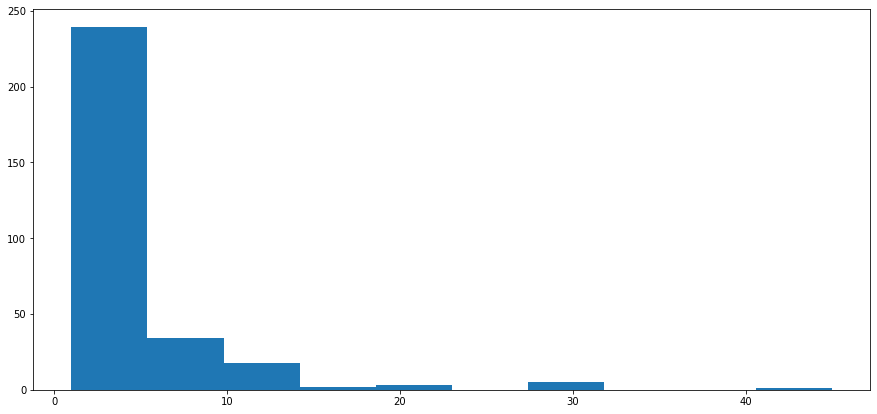

In [17]:
plt.hist([len(track) for track in tracks])

(array([19., 10.,  2.,  3.,  0.,  4.,  1.,  0.,  0.,  1.]),
 array([ 8. , 11.7, 15.4, 19.1, 22.8, 26.5, 30.2, 33.9, 37.6, 41.3, 45. ]),
 <BarContainer object of 10 artists>)

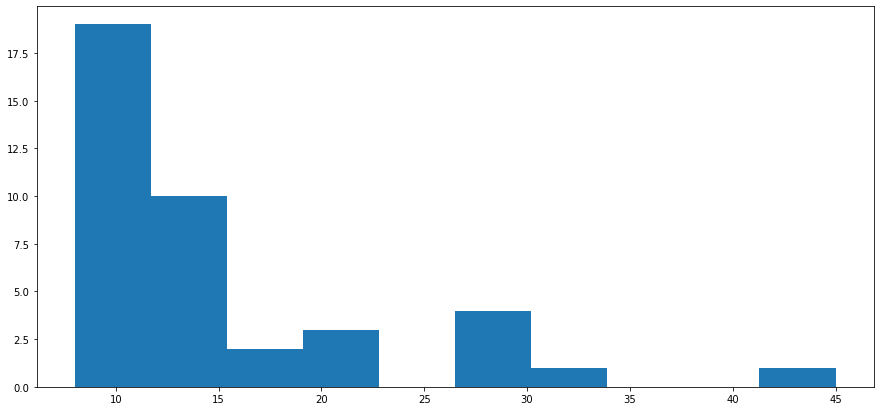

In [18]:
plt.hist([len(track) for track in tracks if len(track) > 7])

### Filter tracks

In [31]:
tracks_filt = [track for track in tracks if len(track) > 20]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [33]:
visualise_raw_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

In [34]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')
viewer.add_tracks(visualise_raw_tracks, name = 'tracks')


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks' at 0x7fcf1e92fac0>

[INFO][2022/11/08 11:58:10 am] Loading configuration file: /home/dayn/.cache/btrack-examples/examples/cell_config.json
[INFO][2022/11/08 11:59:29 am] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/08 11:59:29 am] btrack (v0.4.5) library imported
[INFO][2022/11/08 11:59:29 am] Starting BayesianTracker session
[INFO][2022/11/08 11:59:29 am] Localizing objects from segmentation...
[INFO][2022/11/08 12:01:28 pm] Objects are of type: <class 'dict'>
[INFO][2022/11/08 12:01:29 pm] ...Found 34804 objects in 75 frames.
[INFO][2022/11/08 12:01:29 pm] Objects are of type: <class 'list'>
[INFO][2022/11/08 12:01:29 pm] Starting tracking... 
[INFO][2022/11/08 12:01:29 pm] Tracking objects in frames 0 to 75 (of 75)...
[INFO][2022/11/08 12:01:55 pm]  - Timing (Bayesian updates: 12.01ms, Linking: 1.05ms)
[INFO][2022/11/08 12:01:55 pm]  - Probabilities (Link: 0.91317, Lost: 1.00000)
[INFO][2022/11/08 12:01:55 pm] SUCCESS.
[INFO][2022/1

GLPK Integer Optimizer 5.0
72844 rows, 60505 columns, 84588 non-zeros
60505 integer variables, all of which are binary
Preprocessing...
36422 rows, 60505 columns, 84588 non-zeros
60505 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 36422
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
36422 rows, 60505 columns, 84588 non-zeros
*     0: obj =   2.275244439e+05 inf =   0.000e+00 (21557)
Perturbing LP to avoid stalling [1938]...
*  5216: obj =   1.729557534e+05 inf =   0.000e+00 (16106)
* 10373: obj =   1.196583407e+05 inf =   0.000e+00 (10961)
* 13405: obj =   1.081772543e+05 inf =   0.000e+00 (7726)
* 16658: obj =   9.579908683e+04 inf =   0.000e+00 (4955) 1
* 20280: obj =   8.413858037e+04 inf =   0.000e+00 (1700) 1
Removing LP perturbation [22130]...
* 22130: obj =   8.244762093e+04 inf =   0.000e+00 (0) 3
OPTIMAL 

[INFO][2022/11/08 12:02:26 pm] Ending BayesianTracker session


### Inspecting one track (ID == 88)

In [43]:
track_88 = [track for track in tracks if track.ID == 88][0]

In [44]:
track_88

OrderedDict([('ID', 88), ('t', [9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55]), ('x', [834.035885725516, 832.8295059954372, 832.522478258575, 840.3349514841034, 840.6639711125409, 850.3918011953299, 850.3996095936354, 835.7991743703031, 834.1049589572241, 830.1946491568551, 826.2843393564862, 844.117825450515, 840.2187149625381, 838.552775807232, 836.8868366519259, 835.2208974966198, 833.5549583413137, 810.1092171157385, 812.223354644207, 819.4245953137269, 816.2166977965205, 822.0209434678085, 834.0356318523648, 838.1080810004441, 845.4672279658796, 848.4587165359434, 851.4502051060072, 854.4416936760709, 858.553711780073, 866.9403958730081, 875.3270799659433, 883.7137640588785, 892.1004481518137, 889.8233780148694, 893.3406571060063, 889.4336077731319, 882.6157116315188, 875.9753818894924, 869.335052147466, 862.6947224054395, 868.2968345636052, 849.8167056725047, 819.6741762184471, 819.6741762184471, 815.3971548441418]), ('y', [316.36018295514236, 325.5897907887962, 333.1097537247334, 339.55161130597634, 322.08875568660903, 305.67554085127716, 316.2638700042634, 315.4842709290076, 305.9324424805344, 300.1353881094332, 294.33833373833204, 295.19705257171654, 289.42236296118284, 283.56558068201923, 277.7087984028556, 271.852016123692, 265.9952338445284, 255.11313962926818, 258.8483988171818, 249.12999384958601, 254.69310241587587, 257.1046298422295, 252.93399049035315, 247.5227180646767, 238.6860431815134, 234.83572485866313, 230.98540653581284, 227.13508821296256, 239.65229909220585, 241.49031114516342, 243.32832319812098, 245.16633525107855, 247.00434730403612, 276.3113602995694, 286.6730290915414, 256.9795717126848, 243.30297425355909, 231.51861852339817, 219.73426279323726, 207.94990706307635, 201.23678475236485, 218.45765964000054, 221.60956106690674, 221.60956106690674, 199.99811548415454]), ('z', [0.0, 0.0, 0.5977570606968232, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.619885135120953, -3.239770270241906, 0.0, 0.0, -1.890285240635711, -3.780570481271422, -5.670855721907133, -7.561140962542844, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.6076255737921799, -1.2152511475843597, -1.8228767213765396, 0.0, 3.683522037864077, 7.367044075728154, 11.050566113592232, 14.734088151456309, 0.0, 0.0, 0.0, 0.0, -1.5269076358166362, -3.0538152716332725, -4.580722907449909, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 88), ('root', 88), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, True, False, False, False, False, False, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, True, True, True, False, True, True, True, True, False, False, False, False, True, True, True, False, False, False, True, False]), ('solidity', array([0.98546302, 0.97742043,        nan, 0.99023594, 0.93209671,
       0.93941997, 0.95462296, 0.95604359, 0.93653228,        nan,
              nan, 0.98958171, 0.99227975,        nan,        nan,
              nan,        nan, 0.97898882, 0.97655281, 0.96986611,
       0.97896173, 0.98345718, 0.97740387, 0.98823705, 0.96701414,
              nan,        nan,        nan, 0.93706   ,        nan,
              nan,        nan,        nan, 0.99043419, 0.96011603,
       0.98736927, 0.98629288,        nan,        nan,        nan,
       0.9606873 , 0.94866044, 0.94634667,        nan, 0.97915404])), ('mean_intensity', array([1917.69098952, 1910.77591852,           nan, 2213.67220096,
       2032.42553232, 1936.51888596, 1950.46373972, 1738.75285848,
       1775.29853214,           nan,           nan, 2148.38487656,
       2417.55436417,           nan,           nan,           nan,
                 nan, 2423.29686929, 2323.05688085, 2450.00449402,
       1998.95552785, 1823.45155849, 1674.38900406, 1787.84379253,

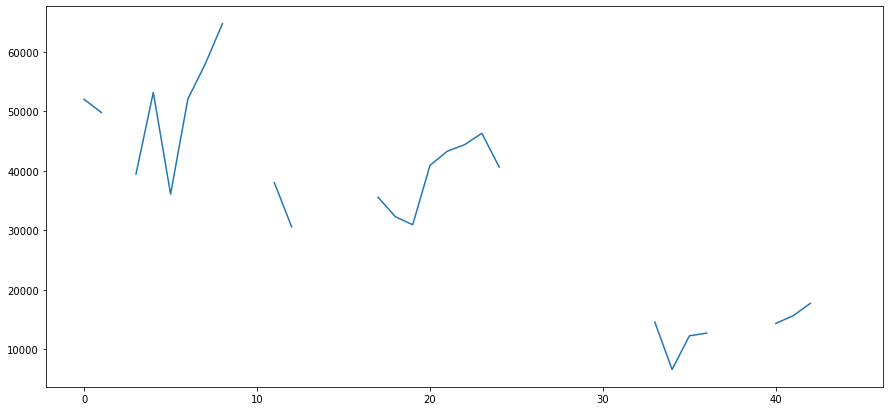

In [46]:
plt.plot(track_88.properties['area'])

### Inspecting one track (ID == 30)

In [47]:
track_30 = [track for track in tracks if track.ID == 30][0]

In [48]:
track_30

OrderedDict([('ID', 30), ('t', [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]), ('x', [379.45112429730295, 379.45112429730295, 405.79978694868885, 417.81198359469926, 417.5936860390375, 416.8493543118679, 416.1050225846983, 415.3606908575287, 411.6443831939605, 407.3872705131449, 403.13015783232936, 429.71176827830783, 437.413356322254, 445.1149443662002, 421.68351470511203, 420.3135170993964, 418.94351949368075, 417.5735218879651, 416.2035242822495, 414.83352667653384, 427.2657682505036, 424.81507744345265, 422.3643866364017, 430.6909392817229, 430.00577493583853, 429.3206105899542, 428.63544624406984, 427.9502818981855, 412.9446933865853]), ('y', [301.04647287500245, 301.04647287500245, 286.1010590915412, 291.8344525138661, 284.2596929474022, 277.99801471213095, 271.7363364768597, 265.4746582415885, 280.1366232580449, 275.8739895713804, 271.61135588471586, 273.5791593781338, 273.8910843304629, 274.203009282792, 275.017835117392, 271.8534641498335, 268.689093182275, 265.52472221471646, 262.36035124715795, 259.19598027959944, 254.73672836446457, 246.31517415032687, 237.89361993618917, 240.9480994223008, 233.45963906524406, 225.97117870818732, 218.4827183511306, 210.99425799407385, 198.15644277077763]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, -0.5806085604232728, -1.1612171208465456, -1.7418256812698183, 0.0, -1.684022437675976, -3.368044875351952, 0.0, 3.3106086158978334, 6.621217231795667, 0.0, -1.8816972423887663, -3.7633944847775327, -5.6450917271662995, -7.526788969555065, -9.408486211943831, 0.0, -3.817175619732566, -7.634351239465132, 0.0, -2.1609441173853075, -4.321888234770615, -6.482832352155922, -8.64377646954123, 0.0]), ('parent', 30), ('root', 30), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, False, False, False, True, True, True, False, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, False]), ('solidity', array([0.91222006,        nan, 0.96734312, 0.95192706, 0.96470469,
              nan,        nan,        nan, 0.98741326,        nan,
              nan, 0.95389682,        nan,        nan, 0.95550461,
              nan,        nan,        nan,        nan,        nan,
       0.98210676,        nan,        nan, 0.95112573,        nan,
              nan,        nan,        nan, 0.98192082])), ('mean_intensity', array([1349.65813765,           nan, 1283.91726632, 1469.73530692,
       1297.37613457,           nan,           nan,           nan,
       1590.48341232,           nan,           nan, 1766.99318403,
                 nan,           nan, 1787.32428349,           nan,
                 nan,           nan,           nan,           nan,
       1363.41014466,           nan,           nan, 1463.08064259,
                 nan,           nan,           nan,           nan,
       1652.98500837])), ('major_axis_length', array([337.89174021,          nan, 290.86143327, 319.97140276,
       330.91122087,          nan,          nan,          nan,
       287.72200229,          nan,          nan, 276.73408176,
                nan,          nan, 246.93564593,          nan,
                nan,          nan,          nan,          nan,
       184.70926755,          nan,          nan, 199.63954179,
                nan,          nan,          nan,          nan,
       143.10357685])), ('area', array([30875.,    nan, 27933., 27564., 28535.,    nan,    nan,    nan,
       24476.,    nan,    nan, 22594.,    nan,    nan, 22505.,    nan,
          nan,    nan,    nan,    nan, 16521.,    nan,    nan, 18799.,
          nan,    nan,    nan,    nan, 13741.])), ('orientation', array([-0.20078042,         nan, -0.2100477 , -0.08192768, -0.0888234 ,
               nan,         nan,         nan, -0.1416401 ,         nan,
               nan, -0.21919571,         nan,         nan, -0.33657469,
               nan,         nan

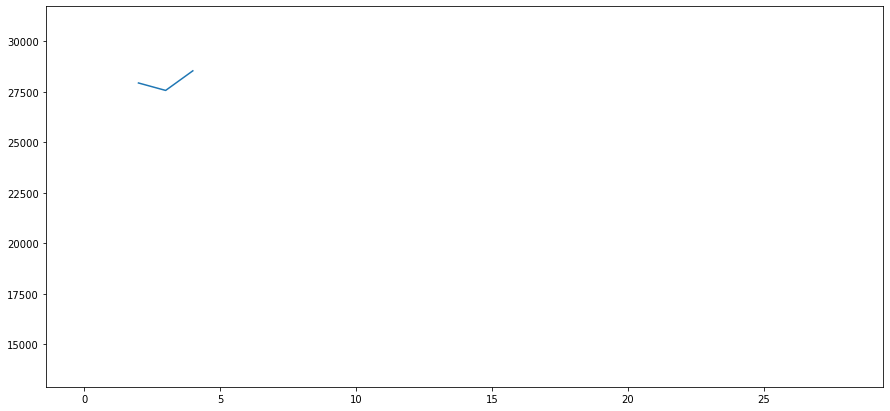

In [49]:
plt.plot(track_30.properties['area'])

### Now doing on the whole FOV

In [50]:
gfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch1.zarr/')
rfp = da.from_zarr('/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch2.zarr/')
gfp = da.sum(gfp, axis = 1, dtype='u2')
rfp = da.sum(rfp, axis = 1, dtype='u2')
masks = da.from_zarr(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tzxy_stack_ch99.zarr/',)# chunks = gfp.chunks)

In [51]:
FEATURES = [
  "area",
  "major_axis_length",
  "minor_axis_length",
  "orientation",
  "solidity",
  "mean_intensity",
]

In [52]:
%%time

objects = btrack.utils.segmentation_to_objects(
    masks, 
    gfp,
    properties = tuple(FEATURES), 
)

[INFO][2022/08/08 01:54:52 pm] Localizing objects from segmentation...
[INFO][2022/08/08 01:54:52 pm] Found intensity_image data
[INFO][2022/08/08 01:54:52 pm] Calculating weighted centroids using intensity_image
[INFO][2022/08/08 02:01:25 pm] Objects are of type: <class 'dict'>
[INFO][2022/08/08 02:01:25 pm] ...Found 34804 objects in 75 frames.


CPU times: user 19min 2s, sys: 39.9 s, total: 19min 42s
Wall time: 6min 33s


In [55]:
objects[0]

{'ID': 0, 'x': 228.89509612655968, 'y': 52.45460626056397, 'z': 0.0, 't': 0, 'dummy': False, 'states': 0, 'label': 5, 'prob': 0.0, 'area': 8280, 'major_axis_length': 142.1681837092044, 'minor_axis_length': 74.98138905075203, 'orientation': 0.7685315327700352, 'solidity': 0.9757247230732972, 'mean_intensity': 1223.1384057971015}

In [101]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

    # configure the tracker using a config file
    tracker.configure_from_file(
        '/home/dayn/analysis/BayesianTracker/models/test_config.json'
    )
    tracker.verbose = True

    tracker.max_search_radius = 400
    
    # use visual features to track
    tracker.features = FEATURES
    
    # append the objects to be tracked
    tracker.append(objects)

    # set the volume
    tracker.volume=((0, 6048), (0, 6048), (-1e5, 1e5))

    # track them (in interactive mode)
    tracker.track_interactive(step_size=25)

    # generate hypotheses and run the global optimizer
    tracker.optimize()
    
    # store config
    cfg = tracker.configuration

    tracker.export(f'/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5', obj_type='obj_type_1')

    # get the tracks in a format for napari visualization (optional)
    visualise_tracks, properties, graph = tracker.to_napari(ndim=2)
    
    tracks = tracker.tracks

[INFO][2022/08/08 04:16:07 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/08/08 04:16:07 pm] btrack (v0.4.5) library imported
[INFO][2022/08/08 04:16:07 pm] Starting BayesianTracker session
[INFO][2022/08/08 04:16:07 pm] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/test_config.json
[INFO][2022/08/08 04:16:07 pm] Setting max_search_radius -> 400
[INFO][2022/08/08 04:16:07 pm] Setting features -> ['area', 'major_axis_length', 'minor_axis_length', 'orientation', 'solidity', 'mean_intensity']
[INFO][2022/08/08 04:16:07 pm] Objects are of type: <class 'list'>
[INFO][2022/08/08 04:16:07 pm] Setting volume -> ((0, 6048), (0, 6048), (-100000.0, 100000.0))
[INFO][2022/08/08 04:16:07 pm] Starting tracking... 
[INFO][2022/08/08 04:16:07 pm] Tracking objects in frames 0 to 24 (of 75)...
[INFO][2022/08/08 04:16:21 pm]  - Timing (Bayesian updates: 507.55ms, Linking: 10.39ms)
[INFO][2022/08/08 04:16:21 pm]

GLPK Integer Optimizer 5.0
70612 rows, 58583 columns, 81860 non-zeros
58583 integer variables, all of which are binary
Preprocessing...
35306 rows, 58583 columns, 81860 non-zeros
58583 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 35306
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
35306 rows, 58583 columns, 81860 non-zeros
*     0: obj =   2.180590624e+05 inf =   0.000e+00 (15561)
Perturbing LP to avoid stalling [2275]...
*  4820: obj =   1.736073588e+05 inf =   0.000e+00 (10430)
*  8984: obj =   1.480559112e+05 inf =   0.000e+00 (6510)
* 13185: obj =   1.226782295e+05 inf =   0.000e+00 (2694) 2
Removing LP perturbation [16161]...
* 16161: obj =   1.171903126e+05 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+ 16161: mip =     not found yet >

[INFO][2022/08/08 04:16:55 pm] Writing tracks/obj_type_1
[WARNING][2022/08/08 04:16:55 pm] Removing tracks/obj_type_1.
[INFO][2022/08/08 04:16:55 pm] Writing dummies/obj_type_1
[INFO][2022/08/08 04:16:55 pm] Writing LBEP/obj_type_1
[INFO][2022/08/08 04:16:55 pm] Writing fates/obj_type_1
[INFO][2022/08/08 04:16:56 pm] Closing HDF file: /mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/zarr/tracks.h5
[INFO][2022/08/08 04:16:57 pm] Ending BayesianTracker session
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py:1068: UserWarning: No readers found to try reading /run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy/Folder_20220808/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi.
  warnings.warn(


New config

In [100]:
np.mean([len(track) for track in tracks if len(track)>30])

37.63636363636363

(array([25., 13.,  7.,  2.,  1.,  5.,  0.,  0.,  1.,  1.]),
 array([31. , 34.6, 38.2, 41.8, 45.4, 49. , 52.6, 56.2, 59.8, 63.4, 67. ]),
 <BarContainer object of 10 artists>)

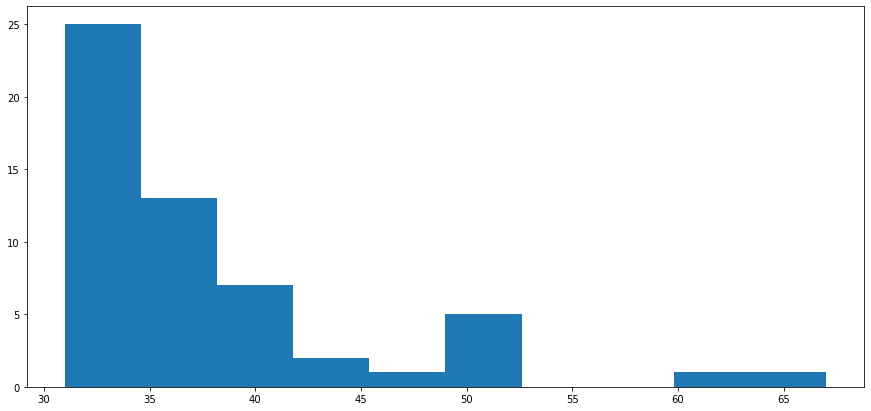

In [98]:
plt.hist([len(track) for track in tracks if len(track)>30])

Previous config (default particle track)

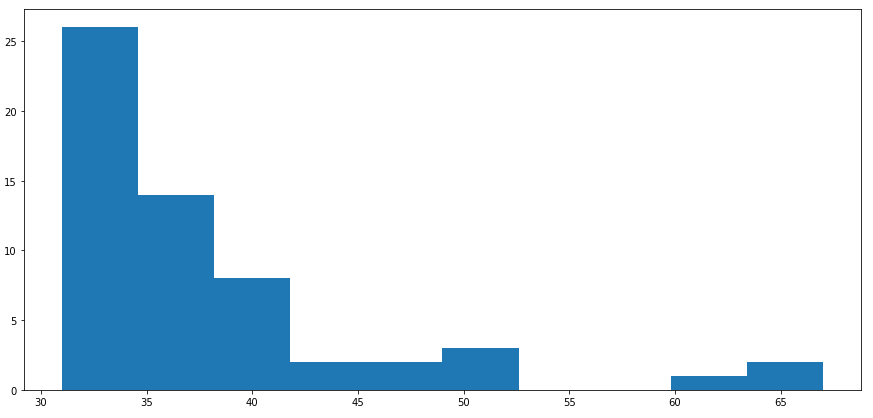

checking dummies

In [99]:
track_5603 = [track for track in tracks if track.ID ==5603][0]
track_5603

OrderedDict([('ID', 5603), ('t', [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49]), ('x', [3047.1168777713515, 3047.1168777713515, 3047.1168777713515, 3047.479679936128, 3048.315427767228, 3049.151175598328, 3046.203771370904, 3044.4885814265667, 3056.2197044121813, 3059.7986792495217, 3063.5337420995697, 3063.1772768507626, 3068.307408722133, 3059.179253491122, 3063.315221071073, 3065.8018473217744, 3068.2884735724756, 3070.775099823177, 3062.509117185114, 3062.4490239455363, 3062.3889307059585, 3062.3288374663807, 3070.289538923745, 3077.7240386410285, 3081.663984338046, 3085.603930035063, 3089.5438757320803, 3093.4838214290976, 3097.423767126115, 3066.443905182207, 3093.8409434401165, 3093.8409434401165, 3093.8409434401165, 3101.9109125226387]), ('y', [3449.7303191195706, 3449.7303191195706, 3449.7303191195706, 3456.3984814989376, 3461.96324949098, 3467.5280174830227, 3452.450343401713, 3450.2654865380814, 3438.9581450591486, 3439.9249931644986, 3439.158631131773, 3447.940277766973, 3451.1263978993406, 3467.887251935008, 3471.819967041474, 3476.0611867099433, 3480.302406378413, 3484.5436260468823, 3473.017672782597, 3474.5315276957735, 3476.04538260895, 3477.5592375221268, 3480.767907719868, 3484.053782685265, 3488.586957638912, 3493.1201325925585, 3497.6533075462053, 3502.186482499852, 3506.7196574534987, 3490.9438698889635, 3512.3951157987663, 3512.3951157987663, 3512.3951157987663, 3508.5560733948646]), ('z', [0.0, 0.0, 0.0, 0.0, 0.5636462075174375, 1.127292415034875, 0.0, -1.207243648324464, 0.0, 0.0, 1.4005909831353671, 0.0, 3.0375999043172013, 0.0, 0.0, 1.3404739063432363, 2.6809478126864725, 4.021421719029709, 0.0, -0.8344365549743777, -1.6688731099487555, -2.5033096649231332, 0.0, 0.0, 2.0575511922738166, 4.115102384547633, 6.17265357682145, 8.230204769095266, 10.287755961369083, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 5603), ('root', 5603), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, True, False, True, True, False, True, False, False, True, False, True, False, False, True, True, True, False, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False]), ('solidity', array([0.81947218,        nan,        nan, 0.84035123,        nan,
              nan, 0.84916676,        nan, 0.92057938, 0.9448096 ,
              nan, 0.9622771 ,        nan, 0.96339263, 0.97806687,
              nan,        nan,        nan, 0.9687796 ,        nan,
              nan,        nan, 0.94436078, 0.94447733,        nan,
              nan,        nan,        nan,        nan, 0.86015811,
       0.94367943,        nan,        nan, 0.97444895])), ('mean_intensity', array([1648.79431012,           nan,           nan, 2015.61601806,
                 nan,           nan, 2127.85400516,           nan,
       2015.32782175, 2022.90400344,           nan, 2119.36354269,
                 nan, 2329.183172  , 2012.2899463 ,           nan,
                 nan,           nan, 1928.64412877,           nan,
                 nan,           nan, 2731.30339166, 3070.9322031 ,
                 nan,           nan,           nan,           nan,
                 nan, 1238.52367802, 2852.36086386,           nan,
                 nan, 2248.82207968])), ('major_axis_length', array([821.1754053 ,          nan,          nan, 616.62318756,
                nan,          nan, 699.08919171,          nan,
       579.45004397, 612.26279042,          nan, 527.91514729,
                nan, 461.34973985, 509.88728827,          nan,
                nan,          nan, 481.17754355,          nan,
                nan,          nan, 335.94856894, 325.41075584,
                nan,          nan,          nan,          nan,
                nan, 264.93378121, 115.88361878,          nan,
                nan, 123.9823849 ])), ('area', array([159230.,     nan

### Filter tracks

In [75]:
tracks_filt = [track for track in tracks if len(track) > 30]
visualise_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks_filt, ndim = 2)

In [76]:
viewer = napari.Viewer()
viewer.add_image(gfp, name="gfp", 
                 #contrast_limits=[0,255],
                 blending = 'additive', colormap = 'green')
# viewer.add_image(rfp, name="rfp", 
#                 # contrast_limits=[0,55], 
#                  blending = 'additive', colormap = 'magenta')
viewer.add_labels(masks, name = 'masks')
viewer.add_tracks(visualise_tracks, name = 'tracks_filtered')

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'tracks_filtered' at 0x7f0bfb3aafa0>

#### Inspecting the longest track

In [63]:
import numpy as np

In [74]:
sorted([(len(track), track.ID) for track in tracks if len(track)>30])

[(31, 770),
 (31, 817),
 (31, 908),
 (31, 1141),
 (31, 1804),
 (31, 2531),
 (31, 6555),
 (31, 9796),
 (31, 10174),
 (31, 10816),
 (31, 14280),
 (32, 96),
 (32, 646),
 (32, 1341),
 (32, 1839),
 (32, 5961),
 (33, 43),
 (33, 5165),
 (33, 10219),
 (33, 10423),
 (33, 12320),
 (33, 13724),
 (33, 13731),
 (34, 619),
 (34, 2114),
 (34, 5603),
 (35, 560),
 (35, 665),
 (35, 12576),
 (36, 3401),
 (36, 5139),
 (36, 12727),
 (37, 2557),
 (37, 4024),
 (37, 4871),
 (37, 5122),
 (37, 12590),
 (38, 740),
 (38, 5921),
 (38, 10997),
 (39, 7356),
 (40, 364),
 (40, 1659),
 (40, 2009),
 (41, 3465),
 (41, 4863),
 (41, 11442),
 (41, 11531),
 (43, 2696),
 (44, 3802),
 (48, 939),
 (48, 4947),
 (49, 3665),
 (49, 6812),
 (50, 420),
 (60, 5525),
 (67, 1947),
 (67, 3206)]

In [82]:
track_5603 = [track for track in tracks if track.ID ==5603][0]

In [83]:
track_5603

OrderedDict([('ID', 5603), ('t', [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49]), ('x', [3047.1168777713515, 3047.1168777713515, 3047.1168777713515, 3047.479679936128, 3048.315427767228, 3049.151175598328, 3046.203771370904, 3044.4885814265667, 3056.2197044121813, 3059.7986792495217, 3063.5337420995697, 3063.1772768507626, 3068.307408722133, 3059.179253491122, 3063.315221071073, 3065.8018473217744, 3068.2884735724756, 3070.775099823177, 3062.509117185114, 3062.4490239455363, 3062.3889307059585, 3062.3288374663807, 3070.289538923745, 3077.7240386410285, 3081.663984338046, 3085.603930035063, 3089.5438757320803, 3093.4838214290976, 3097.423767126115, 3066.443905182207, 3093.8409434401165, 3093.8409434401165, 3093.8409434401165, 3101.9109125226387]), ('y', [3449.7303191195706, 3449.7303191195706, 3449.7303191195706, 3456.3984814989376, 3461.96324949098, 3467.5280174830227, 3452.450343401713, 3450.2654865380814, 3438.9581450591486, 3439.9249931644986, 3439.158631131773, 3447.940277766973, 3451.1263978993406, 3467.887251935008, 3471.819967041474, 3476.0611867099433, 3480.302406378413, 3484.5436260468823, 3473.017672782597, 3474.5315276957735, 3476.04538260895, 3477.5592375221268, 3480.767907719868, 3484.053782685265, 3488.586957638912, 3493.1201325925585, 3497.6533075462053, 3502.186482499852, 3506.7196574534987, 3490.9438698889635, 3512.3951157987663, 3512.3951157987663, 3512.3951157987663, 3508.5560733948646]), ('z', [0.0, 0.0, 0.0, 0.0, 0.5636462075174375, 1.127292415034875, 0.0, -1.207243648324464, 0.0, 0.0, 1.4005909831353671, 0.0, 3.0375999043172013, 0.0, 0.0, 1.3404739063432363, 2.6809478126864725, 4.021421719029709, 0.0, -0.8344365549743777, -1.6688731099487555, -2.5033096649231332, 0.0, 0.0, 2.0575511922738166, 4.115102384547633, 6.17265357682145, 8.230204769095266, 10.287755961369083, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 5603), ('root', 5603), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, True, False, True, True, False, True, False, False, True, False, True, False, False, True, True, True, False, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False]), ('solidity', array([0.81947218,        nan,        nan, 0.84035123,        nan,
              nan, 0.84916676,        nan, 0.92057938, 0.9448096 ,
              nan, 0.9622771 ,        nan, 0.96339263, 0.97806687,
              nan,        nan,        nan, 0.9687796 ,        nan,
              nan,        nan, 0.94436078, 0.94447733,        nan,
              nan,        nan,        nan,        nan, 0.86015811,
       0.94367943,        nan,        nan, 0.97444895])), ('mean_intensity', array([1648.79431012,           nan,           nan, 2015.61601806,
                 nan,           nan, 2127.85400516,           nan,
       2015.32782175, 2022.90400344,           nan, 2119.36354269,
                 nan, 2329.183172  , 2012.2899463 ,           nan,
                 nan,           nan, 1928.64412877,           nan,
                 nan,           nan, 2731.30339166, 3070.9322031 ,
                 nan,           nan,           nan,           nan,
                 nan, 1238.52367802, 2852.36086386,           nan,
                 nan, 2248.82207968])), ('major_axis_length', array([821.1754053 ,          nan,          nan, 616.62318756,
                nan,          nan, 699.08919171,          nan,
       579.45004397, 612.26279042,          nan, 527.91514729,
                nan, 461.34973985, 509.88728827,          nan,
                nan,          nan, 481.17754355,          nan,
                nan,          nan, 335.94856894, 325.41075584,
                nan,          nan,          nan,          nan,
                nan, 264.93378121, 115.88361878,          nan,
                nan, 123.9823849 ])), ('area', array([159230.,     nan